In [3]:
! pip install torchsummary

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models

In [2]:
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs
! unzip cuhk-face-sketch-database-cufs.zip

In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def load_and_preprocess_image(file_path, size):
    image = cv2.imread(file_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    return image

def augment_image(image):
    augmentations = [
        lambda x: x,  # original image
        lambda x: cv2.flip(x, 1),  # horizontal flip
        lambda x: cv2.flip(x, -1),  # vertical flip
        lambda x: cv2.flip(cv2.flip(x, -1), 1),  # both flips
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE), 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE), 1)
    ]
    return [aug(image) for aug in augmentations]

def process_images(file_list, folder_path, size):
    images = []
    for file in tqdm(file_list, desc=f"Processing {os.path.basename(folder_path)}"):
        image = load_and_preprocess_image(os.path.join(folder_path, file), size)
        images.extend(augment_image(image))
    return np.array(images)

def load_and_augment_data(image_path, sketch_path, size=256, test_split=0.2):
    image_files = sorted_alphanumeric(os.listdir(image_path))
    sketch_files = sorted_alphanumeric(os.listdir(sketch_path))

    assert len(image_files) == len(sketch_files), "Mismatch in number of images and sketches"
    print(f"Total number of original files: {len(image_files)}")

    images = process_images(image_files, image_path, size)
    sketches = process_images(sketch_files, sketch_path, size)

    # Split data into train and test sets
    train_images, test_images, train_sketches, test_sketches = train_test_split(
        images, sketches, test_size=test_split, random_state=42
    )

    print(f"Train set size: {len(train_images)}, Test set size: {len(test_images)}")

    return (train_sketches, train_images), (test_sketches, test_images)

# Usage
SIZE = 128

#Kaggle paths
# image_path = '/kaggle/input/cuhk-face-sketch-database-cufs/photos'
# sketch_path = '/kaggle/input/cuhk-face-sketch-database-cufs/sketches'

#Colab paths
image_path = '/content/photos'
sketch_path = '/content/sketches'

(train_sketch_image, train_image), (test_sketch_image, test_image) = load_and_augment_data(image_path, sketch_path, SIZE)

print('Train sketch shape:', train_sketch_image.shape)
print('Train image shape:', train_image.shape)
print('Test sketch shape:', test_sketch_image.shape)
print('Test image shape:', test_image.shape)

Total number of original files: 188


Processing sketches: 100%|██████████| 188/188 [00:00<00:00, 1473.34it/s]


Train set size: 1203, Test set size: 301
Train sketch shape: (1203, 128, 128, 3)
Train image shape: (1203, 128, 128, 3)
Test sketch shape: (301, 128, 128, 3)
Test image shape: (301, 128, 128, 3)


In [7]:
# Define image size
image_size = 128  # Ensure this matches the SIZE you used in reshaping

# Define transformations for RGB images
trans_rgb = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images
])

# Define transformations for sketches
trans_sketch = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    #transforms.Grayscale(num_output_channels=1),  # Convert sketches to grayscale if needed
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

# Function to apply transformations
def apply_transforms(images, transform):
    images_pil = [transforms.ToPILImage()(image) for image in images]
    return torch.stack([transform(image) for image in images_pil])

# Apply transformations
train_rgb_tensors = apply_transforms(train_image, trans_rgb)
train_sketch_tensors = apply_transforms(train_sketch_image, trans_sketch)
test_rgb_tensors = apply_transforms(test_image, trans_rgb)
test_sketch_tensors = apply_transforms(test_sketch_image, trans_sketch)

# Create TensorDatasets
train_dataset = TensorDataset(train_rgb_tensors, train_sketch_tensors)
test_dataset = TensorDataset(test_rgb_tensors, test_sketch_tensors)

# Create DataLoaders
batch_size = 16  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shape of data
for images_rgb, images_sketch in train_loader:
    print("RGB batch shape:", images_rgb.shape)
    print("Sketch batch shape:", images_sketch.shape)
    break

RGB batch shape: torch.Size([16, 3, 128, 128])
Sketch batch shape: torch.Size([16, 3, 128, 128])


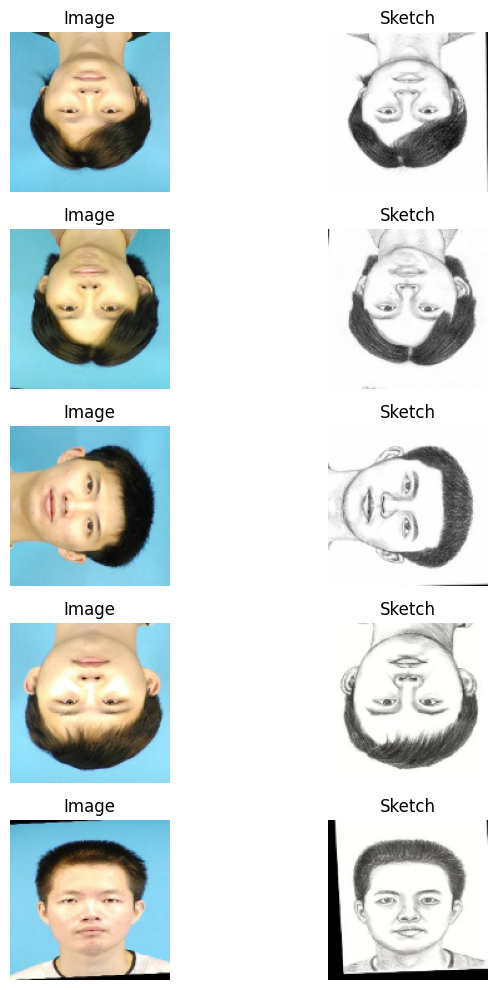

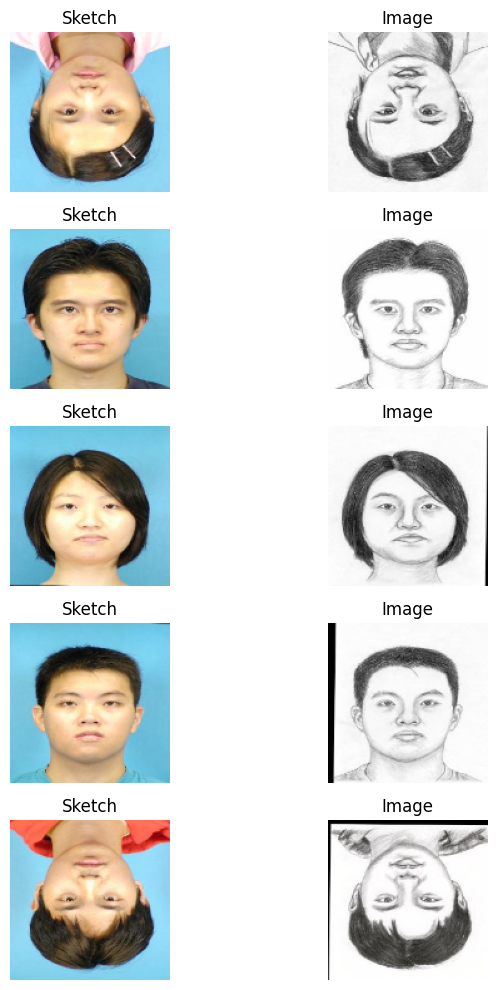

Train dataset size: 1203
Test dataset size: 301


In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
sketches, images = next(dataiter)

# Display a few sketches and their corresponding images
num_images = 5  # Number of images to display
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i in range(num_images):
    sketch = sketches[i]
    image = images[i]

    # Convert tensors to images
    sketch_img = transforms.ToPILImage()(sketch)
    image_img = transforms.ToPILImage()(image)

    # Display the sketch
    axes[i, 0].imshow(sketch_img)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # Display the corresponding image
    axes[i, 1].imshow(image_img)
    axes[i, 1].set_title('Sketch')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Repeat for the test loader
dataiter = iter(test_loader)
sketches, images = next(dataiter)

# Display a few sketches and their corresponding images from the test set
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i in range(num_images):
    sketch = sketches[i]
    image = images[i]

    # Convert tensors to images
    sketch_img = transforms.ToPILImage()(sketch)
    image_img = transforms.ToPILImage()(image)

    # Display the image
    axes[i, 0].imshow(sketch_img)
    axes[i, 0].set_title('Sketch')
    axes[i, 0].axis('off')

    # Display the corresponding sketch
    axes[i, 1].imshow(image_img)
    axes[i, 1].set_title('Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

In [10]:
def get_image_dimensions(data_loader):
    for batch, _ in data_loader:
        return batch.shape[1:]  # Returns

In [11]:
get_image_dimensions(test_loader)

torch.Size([3, 128, 128])

In [58]:
# Original works okay
class Encoder(nn.Module):
    def __init__(self, z_dim, conv_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, conv_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1)
        self.fc_mu = nn.Linear(conv_dim * 4 * 16 * 16, z_dim)
        self.fc_logvar = nn.Linear(conv_dim * 4 * 16 * 16, z_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2(x), 0.2)
        x = F.relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Generator(nn.Module):
    def __init__(self, z_dim, conv_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, conv_dim * 4 * 16 * 16)
        self.deconv1 = nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), -1, 16, 16)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, conv_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1)
        self.fc = nn.Linear(conv_dim * 4 * 16 * 16, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2(x), 0.2)
        x = F.relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class VAE_GAN(nn.Module):
    def __init__(self, z_dim, conv_dim):
        super(VAE_GAN, self).__init__()
        self.encoder = Encoder(z_dim, conv_dim)
        self.generator = Generator(z_dim, conv_dim)
        self.discriminator = Discriminator(conv_dim)
        self.z_dim = z_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z_e = self.reparameterize(mu, logvar)
        x_bar = self.generator(z_e)
        z_p = torch.randn(x.size(0), self.z_dim, device=x.device)
        x_p = self.generator(z_p)
        return x_bar, x_p, mu, logvar

In [40]:
def generate_sketches(model, test_loader, device, num_images=16):
    model.eval()
    generated_images = []
    original_images = []

    with torch.no_grad():
        for i, (test_images, _) in enumerate(test_loader):
            if i * test_loader.batch_size >= num_images:
                break

            test_images = test_images.to(device)

            # Generate sketches
            x_recon, _, _, _ = model(test_images)

            generated_images.extend(x_recon.cpu())
            original_images.extend(test_images.cpu())

            if len(generated_images) >= num_images:
                break

    # Display images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for idx in range(num_images):
        orig_img = original_images[idx].permute(1, 2, 0).numpy()  # Convert to HWC format
        gen_img = generated_images[idx].permute(1, 2, 0).numpy()  # Convert to HWC format

        # Assuming no normalization in the output
        orig_img = np.clip(orig_img, 0, 1)
        gen_img = np.clip(gen_img, 0, 1)

        axes[idx, 0].imshow(orig_img)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(gen_img)
        axes[idx, 1].set_title("Generated Sketch")
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [41]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def train_vae_gan(model, train_loader, test_loader, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    adversarial_loss = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (x_d, target_sketches) in enumerate(train_loader):
            x_d = x_d.to(device)
            target_sketches = target_sketches.to(device)

            optimizer.zero_grad()

            # Forward pass through the model
            x_bar, x_p, mu, logvar = model(x_d)

            # Discriminator forward pass
            d_real = model.discriminator(target_sketches)
            d_fake_bar = model.discriminator(x_bar)
            d_fake_p = model.discriminator(x_p)

            # Compute VAE loss
            vae_l = vae_loss(x_bar, target_sketches, mu, logvar)

            # Compute GAN losses
            g_loss = (adversarial_loss(d_fake_bar, torch.ones_like(d_fake_bar)) +
                      adversarial_loss(d_fake_p, torch.ones_like(d_fake_p))) / 2

            d_loss = (adversarial_loss(d_real, torch.ones_like(d_real)) +
                      adversarial_loss(d_fake_bar, torch.zeros_like(d_fake_bar)) +
                      adversarial_loss(d_fake_p, torch.zeros_like(d_fake_p))) / 3

            # Total loss
            total_loss = vae_l + g_loss + d_loss

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Save sample reconstructed images
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                sample = next(iter(test_loader))[0].to(device)
                target_sketches = next(iter(test_loader))[1].to(device)
                x_bar, x_p, _, _ = model(sample)
                img_grid = torch.cat([sample, x_bar, x_p], dim=0)
                save_image(img_grid, f"reconstruction_epoch_{epoch+1}.png", nrow=16, normalize=True)

    generate_sketches(model, test_loader, device)

In [ ]:
# Set up the model
z_dim = 200
conv_dim = 128
model = VAE_GAN(z_dim=z_dim, conv_dim=conv_dim)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up the learning rate
learning_rate = 0.001  # Adjusted learning rate

# Set the number of epochs
num_epochs = 50  # You can adjust this as needed

# Start training
train_vae_gan(model, train_loader, test_loader, num_epochs, learning_rate, device)

# After training, generate and display sketches
#generate_sketches(model, test_loader, device, num_images=16)

Epoch [1/50], Loss: 72164.4611
Epoch [2/50], Loss: 32899.6682


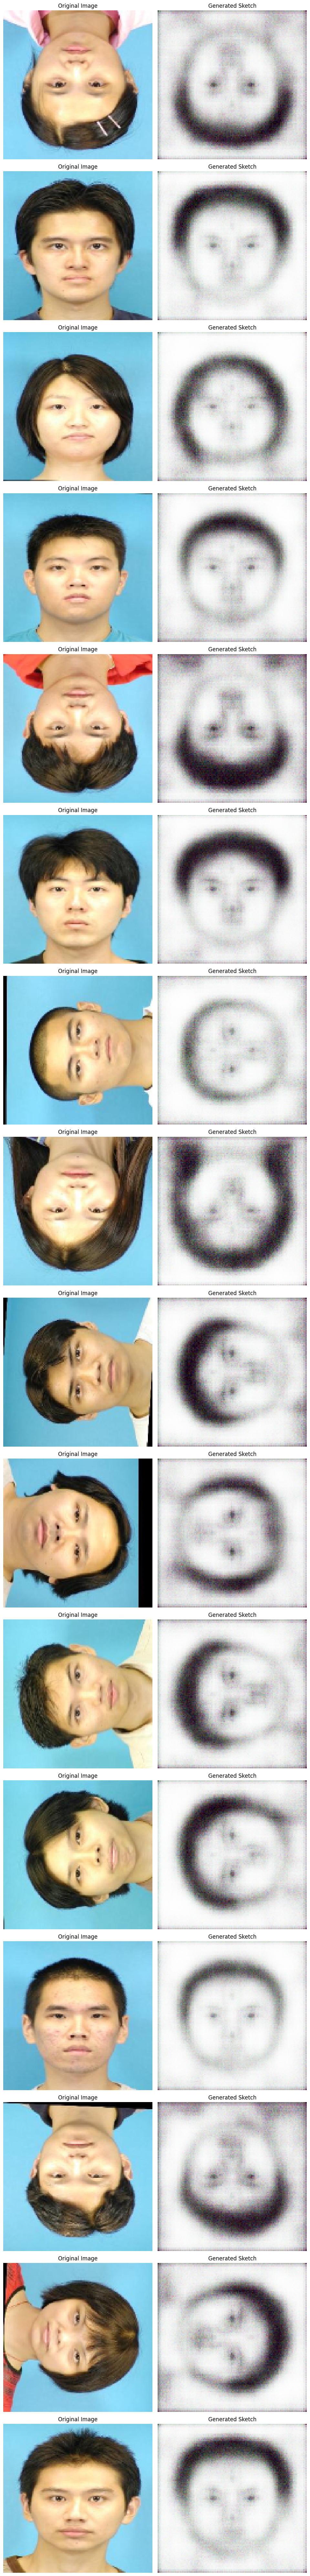

In [57]:
generate_sketches(model, test_loader, device, num_images=16)